In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU, LSTM
from keras import optimizers
import tkinter as tk
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure


In [4]:

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
ticker = 'eth-USD'
# Download data from Yahoo Finance
dataraw =  yf.download(ticker)

# use feature 'Date' & 'Close'
dataset = pd.DataFrame(dataraw['Close'])

#Min-Max Normalization
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])

# Partition data into data train, val & test
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.7)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.2)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size = 256
epochs = 100

# Define GRU model
regressorGRU = Sequential()
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=hidden_unit, return_sequences=False, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer=optimizers.Adam(learning_rate), loss='mean_squared_error')

[*********************100%***********************]  1 of 1 completed


In [5]:
# Define LSTM model
regressorLSTM = Sequential()
regressorLSTM.add(LSTM(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=hidden_unit, return_sequences=True, activation='tanh'))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=hidden_unit, return_sequences=False, activation='tanh'))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(Dense(units=1))
regressorLSTM.compile(optimizer=optimizers.Adam(learning_rate), loss='mean_squared_error')

# Train the models
history_gru = regressorGRU.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs)
history_lstm = regressorLSTM.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs)
# Combine predictions from both models
pred_gru = regressorGRU.predict(x_test)
pred_lstm = regressorLSTM.predict(x_test)
pred = (pred_gru + pred_lstm) / 2

# Get the train and validation loss from the history object
train_loss_gru = history_gru.history['loss'][-1]
val_loss_gru = history_gru.history['val_loss'][-1]
train_loss_lstm = history_lstm.history['loss'][-1]
val_loss_lstm = history_lstm.history['val_loss'][-1]


Epoch 1/100
6/6 [==============================] - 6s 196ms/step - loss: 0.0499 - val_loss: 0.5142
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0457 - val_loss: 0.4820
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0420 - val_loss: 0.4509
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0381 - val_loss: 0.4205
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0351 - val_loss: 0.3908
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0321 - val_loss: 0.3612
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0298 - val_loss: 0.3321
Epoch 8/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0276 - val_loss: 0.3048
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0254 - val_loss: 0.2786
Epoch 10/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0239 - val_loss: 0.2543
Epoch 11/100
6/6 [

6/6 [==============================] - 0s 13ms/step - loss: 7.9666e-04 - val_loss: 0.0013
Epoch 83/100
6/6 [==============================] - 0s 13ms/step - loss: 8.8455e-04 - val_loss: 0.0013
Epoch 84/100
6/6 [==============================] - 0s 12ms/step - loss: 9.9038e-04 - val_loss: 0.0013
Epoch 85/100
6/6 [==============================] - 0s 14ms/step - loss: 8.5382e-04 - val_loss: 0.0013
Epoch 86/100
6/6 [==============================] - 0s 17ms/step - loss: 8.4191e-04 - val_loss: 0.0013
Epoch 87/100
6/6 [==============================] - 0s 12ms/step - loss: 9.0789e-04 - val_loss: 0.0013
Epoch 88/100
6/6 [==============================] - 0s 13ms/step - loss: 9.0651e-04 - val_loss: 0.0013
Epoch 89/100
6/6 [==============================] - 0s 13ms/step - loss: 8.3859e-04 - val_loss: 0.0013
Epoch 90/100
6/6 [==============================] - 0s 15ms/step - loss: 8.2858e-04 - val_loss: 0.0013
Epoch 91/100
6/6 [==============================] - 0s 15ms/step - loss: 8.5232e-04 - 

6/6 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 65/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 66/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 67/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 68/100
6/6 [==============================] - 0s 12ms/step - loss: 8.5789e-04 - val_loss: 0.0041
Epoch 69/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 70/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 71/100
6/6 [==============================] - 0s 18ms/step - loss: 9.6005e-04 - val_loss: 0.0039
Epoch 72/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 73/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 74/100
6/

GRU model train loss: 0.0009
GRU model validation loss: 0.0013
LSTM model train loss: 0.0009
LSTM model validation loss: 0.0030


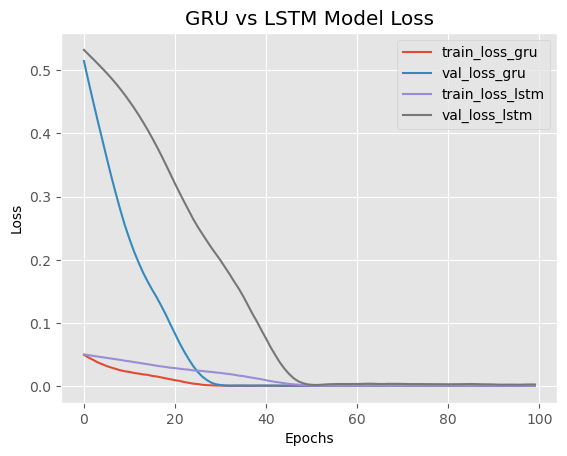

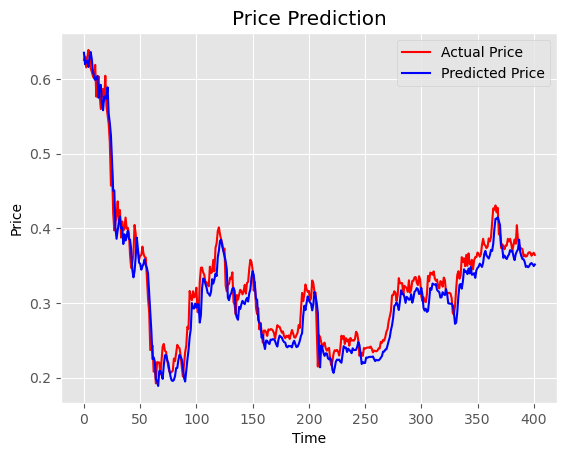

In [6]:
# Print the train and validation loss
print(f'GRU model train loss: {train_loss_gru:.4f}')
print(f'GRU model validation loss: {val_loss_gru:.4f}')
print(f'LSTM model train loss: {train_loss_lstm:.4f}')
print(f'LSTM model validation loss: {val_loss_lstm:.4f}')

# Plot the training and validation loss for the GRU model
plt.plot(history_gru.history['loss'], label='train_loss_gru')
plt.plot(history_gru.history['val_loss'], label='val_loss_gru')

# Plot the training and validation loss for the LSTM model
plt.plot(history_lstm.history['loss'], label='train_loss_lstm')
plt.plot(history_lstm.history['val_loss'], label='val_loss_lstm')

# Set the x-axis label
plt.xlabel('Epochs')

# Set the y-axis label
plt.ylabel('Loss')

# Set the title of the graph
plt.title('GRU vs LSTM Model Loss')

# Add a legend to the graph
plt.legend()

# Show the grap
plt.show()

# Plot the predicted and actual values
plt.plot(y_test, color='red', label='Actual Price')
plt.plot(pred, color='blue', label='Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

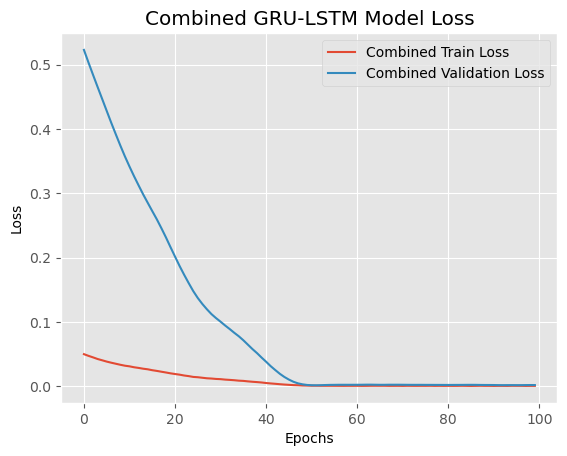

In [7]:

# Plot the combined loss for the combined GRU-LSTM model
combined_loss = (np.array(history_gru.history['loss']) + np.array(history_lstm.history['loss'])) / 2
combined_val_loss = (np.array(history_gru.history['val_loss']) + np.array(history_lstm.history['val_loss'])) / 2
plt.plot(combined_loss, label='Combined Train Loss')
plt.plot(combined_val_loss, label='Combined Validation Loss' )

# Set the plot labels
plt.title('Combined GRU-LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [8]:
# Tabel value of training loss & validation loss
# Create a dataframe to hold the loss values
loss_df = pd.DataFrame({
    'Model': ['GRU', 'LSTM'],
    'Train Loss': [train_loss_gru, train_loss_lstm],
    'Val Loss': [val_loss_gru, val_loss_lstm]
})

# Print the dataframe
print(loss_df.to_string(index=False))

# Implementation model into data test
y_pred = (regressorGRU.predict(x_test)+regressorLSTM.predict(x_test))/2

# Rescale the predicted and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
# Calculate the RMSE
mse = np.mean((y_test - y_pred)**2)
rmse = np.sqrt(mse)
print("Mean Squared Error is:", mse)
print("The Root Mean Squared Error is:", rmse)

# Calculate the MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("The Mean Absolute Percentage Error is:", mape)


# Comparison data test with data prediction
datacompare = pd.DataFrame()
datatest=np.array(dataset['Close'][totaldatatrain+totaldataval+lag:])
datapred= y_pred

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare

Model  Train Loss  Val Loss
  GRU    0.000888  0.001280
 LSTM    0.000908  0.003036
13/13 [==============================] - 0s 2ms/step
Mean Squared Error is: 9960.407420300018
The Root Mean Squared Error is: 99.80184076609017
The Mean Absolute Percentage Error is: 5.244306076547123


,Data Test,Prediction Results
0,3040.916504,3086.146484
1,3062.310303,3012.825928
2,2993.403320,3035.727783
3,3057.606689,3033.551758
4,3104.106445,2996.229736
...,...,...
397,1821.859619,1750.868286
398,1801.728516,1755.173096
399,1812.589478,1748.231812
400,1820.478027,1736.080566


In [9]:
# Prepare data for prediction
last_data = dataset[-lag:].values
last_data_norm = scaler.transform(last_data)
last_data_norm = last_data_norm.reshape(1, lag, 1)

# Predict next day's price using the combined model
predicted_price = (regressorGRU.predict(last_data_norm) + regressorLSTM.predict(last_data_norm)) / 2

# Inverse transform the predicted price to get the actual price
predicted_price = scaler.inverse_transform(predicted_price)[0][0]

# Print the predicted price
print('The predicted price for the next day is:', predicted_price)


# Determine if the price will increase or decrease
current_price = dataraw['Close'][-1]
next_day_price = predicted_price
if next_day_price > current_price:
    print("The Price is predicted to Increase Tomorrow." + "\n")
else:
    print("The Price is predicted to Decrease Tomorrow." + "\n")

1/1 [==============================] - 0s 18ms/step
The predicted price for the next day is: 1748.5216
The Price is predicted to Decrease Tomorrow.



C:\Users\abdul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
